In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import pickle
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm.auto import trange


In [2]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

device = get_default_device()

In [3]:
dataset=pd.read_pickle('/content/integrators_next_state.pickle')

In [12]:
train_set,test_set=train_test_split(dataset,test_size=0.2,random_state=9)
training_set,validation_set=train_test_split(train_set,test_size=0.2,random_state=9)

In [5]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.relu1=nn.ReLU()
        self.h2o = nn.Linear(hidden_size, output_size)
        self.relu2=nn.ReLU()
        self.fc = nn.Linear(output_size, output_size)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden))
        hidden = self.relu1(self.i2h(combined))
        output = self.relu2(self.h2o(hidden))
        output = self.fc(output)
        return output, hidden

    def initHidden(self):
        #return torch.zeros(self.hidden_size).to(device)
        return torch.rand(self.hidden_size).to(device)

In [32]:
EPOCHS   = 5
learning_rate = 0.0001 # If you set this too high, it might explode. If too low, it might not learn
momentum=0.9
batch_size=16
regression_loss_function=nn.MSELoss()
classification_loss_function=nn.CrossEntropyLoss()
n_hidden = 10
dimension=training_set[0][0].size(0)
rnn = RNN(dimension,n_hidden,dimension)
optimizer=optim.SGD(rnn.parameters(),learning_rate)

In [33]:
training_losses=[]
validation_losses=[]


for epoch in trange(EPOCHS, desc="Training epoch"):

  rnn.train()

  for batch_start in range(0, len(training_set), batch_size):
    batch_end = min(batch_start + batch_size, len(training_set))
    batch_traces = training_set[batch_start:batch_end]

    optimizer.zero_grad()

    for trace in batch_traces:
      hidden = rnn.initHidden()
      for i in range(len(trace) - 1):
        output, hidden = rnn(trace[i], hidden)
        hidden = hidden.clone().detach()

        # Calculate losses for regression and classification
        regression_output=output[:4]
        regression_correct=trace[i+1][:4]

        classification_output=output[4:]
        classification_correct=trace[i+1][4:]


        loss_regression = regression_loss_function(regression_output, regression_correct)
        loss_classification = classification_loss_function(classification_output, classification_correct)

        loss = loss_regression + 0.1*loss_classification

        # Accumulate gradients
        loss.backward()

    # Update parameters based on accumulated gradients for the entire batch
    optimizer.step()

  rnn.eval()
  with torch.no_grad():

    training_loss=0
    validation_loss=0

    for trace in training_set:
      hidden = rnn.initHidden()
      for i in range(len(trace) - 1):
        output, hidden = rnn(trace[i], hidden)
        hidden = hidden.clone().detach()

        # Calculate losses for regression and classification
        regression_output=output[:4]
        regression_correct=trace[i+1][:4]

        classification_output=output[4:]
        classification_correct=trace[i+1][4:]


        loss_regression = regression_loss_function(regression_output, regression_correct).item()
        loss_classification = classification_loss_function(classification_output, classification_correct).item()

        training_loss += loss_regression + 0.1*loss_classification
    training_losses.append(training_loss/len(training_set))


    for trace in validation_set:
      hidden = rnn.initHidden()
      for i in range(len(trace) - 1):
        output, hidden = rnn(trace[i], hidden)
        hidden = hidden.clone().detach()

        # Calculate losses for regression and classification
        regression_output=output[:4]
        regression_correct=trace[i+1][:4]

        classification_output=output[4:]
        classification_correct=trace[i+1][4:]


        loss_regression = regression_loss_function(regression_output, regression_correct).item()
        loss_classification = classification_loss_function(classification_output, classification_correct).item()

        validation_loss += loss_regression + 0.1*loss_classification
    validation_losses.append(validation_loss/len(validation_set))


Training epoch:   0%|          | 0/5 [00:00<?, ?it/s]

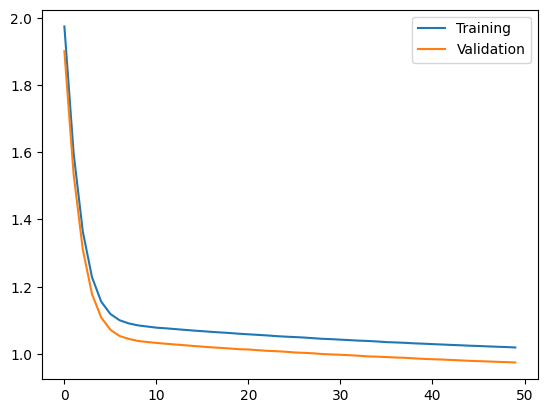

In [29]:
plt.plot(training_losses,label='Training')
plt.plot(validation_losses,label='Validation')
plt.legend()

In [9]:
def evaluate(nn,trace):
    losses_regression=[]
    correct=0
    hidden = nn.initHidden()
    for i in range(len(trace)-1):
        output,hidden=nn(trace[i],hidden)

        regression_output=output[:4]
        regression_correct=trace[i+1][:4]

        classification_output=torch.argmax(output[4:])
        classification_correct=torch.argmax(trace[i+1][4:])

        loss_regression=regression_loss_function(regression_output,regression_correct)
        losses_regression.append(loss_regression.item())

        if classification_output==classification_correct:
          correct+=1

    return losses_regression,correct


Accuracy is 24.642857142857146%
Mean loss is 0.004019883319354752


(array([253., 227., 190.,  52.,  36.,  14.,   4.,   8.,   7.,   7.,   5.,
          4.,   2.,   0.,   2.,   1.,   3.,   1.,   1.,   1.,   1.,   2.,
          1.,   1.,   0.,   3.,   0.,   4.,   1.,   0.,   2.,   1.,   0.,
          0.,   0.,   0.,   1.,   0.,   0.,   0.,   2.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([4.29159118e-05, 1.35879007e-03, 2.67466422e-03, 3.99053837e-03,
        5.30641253e-03, 6.62228668e-03, 7.93816083e-03, 9.25403499e-03,
        1.05699091e-02, 1.18857833e-02, 1.32016574e-02, 1.45175316e-02,
        1.58334058e-02, 1.71492799e-02, 1.84651541e-02, 1.97810282e-02,
        2.10969024e-02, 2.2412

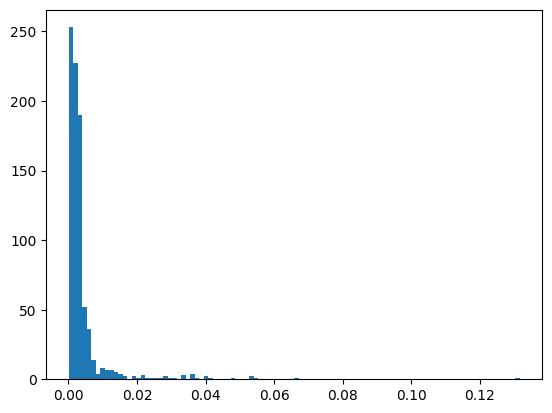

In [31]:
losses=[]
correct=0
tot=0
for trace in test_set:
    trace_losses,trace_correct=evaluate(rnn,trace)
    losses.extend(trace_losses)
    correct+=trace_correct
    tot+=len(trace)-1

print(f"Accuracy is {(correct/tot)*100}%" )
print(f"Mean loss is {np.mean(losses)}")
plt.hist(losses,bins=100)

In [ ]:
print(test_set[5])
hidden=rnn.initHidden()
rnn(test_set[5][0],hidden)

tensor([[0.3066, 0.9117, 0.0195, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000,
         0.0000, 0.0000, 0.2050],
        [0.3066, 0.9117, 0.1543, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.2371],
        [0.4188, 0.9117, 0.1543, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         1.0000, 0.0000, 0.0000]])


(tensor([0.4737, 0.8346, 0.2746, 0.2051, 0.1739, 0.1693, 0.1673, 0.1589, 0.6644,
         0.1985, 0.1675, 0.1263], grad_fn=<SigmoidBackward0>),
 tensor([0.5362, 0.5692, 0.4343, 0.5372, 0.5127, 0.5215, 0.4979, 0.5028, 0.5803,
         0.5993], grad_fn=<SigmoidBackward0>))